https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-4.transformer-post/

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../Data/CleanedData/서울_Cleaned.csv')
data

,Unnamed: 0,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-20
1,1,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-21
2,2,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-22
3,3,0,0,서울,Seoul,0,0,0,0,0,0.0,2020-01-23
4,4,0,1,서울,Seoul,1,0,1,0,1,0.0,2020-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...
1167,1167,6383,5991150,서울,Seoul,2523,0,0,2522,1,63544.0,2023-04-01
1168,1168,6383,5993551,서울,Seoul,2401,0,0,2401,0,63569.0,2023-04-02
1169,1169,6384,5994393,서울,Seoul,842,0,0,842,0,63578.0,2023-04-03
1170,1170,6387,5997981,서울,Seoul,3588,0,0,3588,0,63616.0,2023-04-04


In [3]:
df = data.loc[:, ['stdDay', 'defCnt']]
df.rename(columns = {'stdDay':'Date', 'defCnt':'AC'}, inplace = True)
df['daily_Acc'] = df['AC'] - df['AC'].shift(1)
df.set_index('Date', inplace = True)
df.dropna(inplace = True)
rawdata = df

,AC,daily_Acc
Date,,
2020-01-21,0,0.0
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,1,1.0
2020-01-25,1,0.0


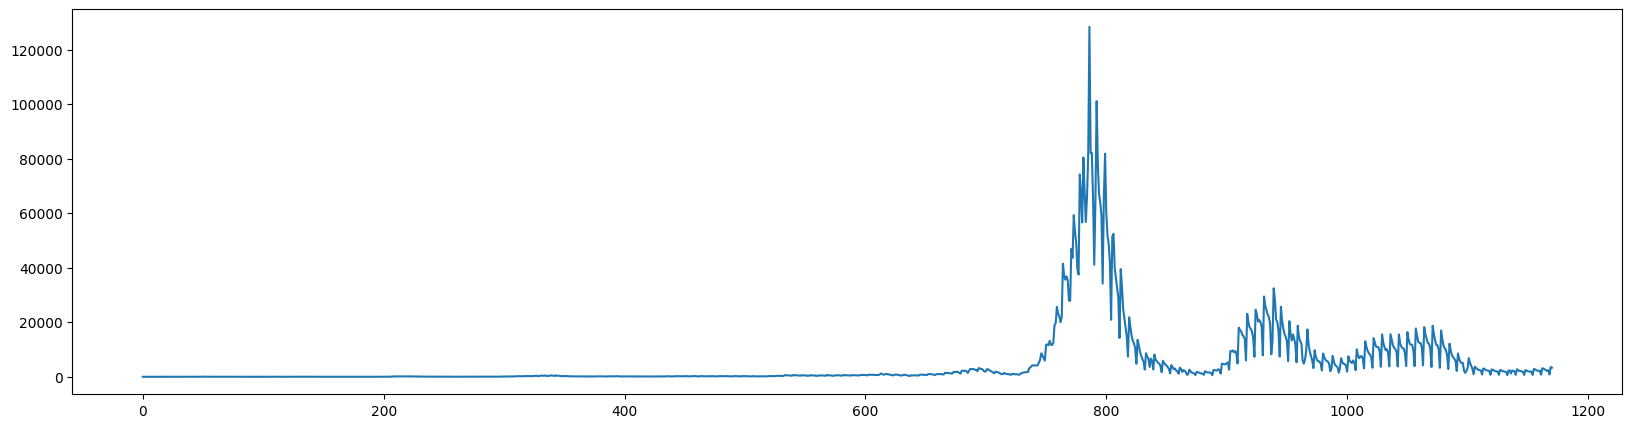

In [4]:
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["daily_Acc"])
rawdata.head()

In [5]:
# MinMaxScaler를 사용하여 데이터를 0~1로 변환
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["daily_Acc"] = min_max_scaler.fit_transform(rawdata["daily_Acc"].to_numpy().reshape(-1,1))

In [6]:
# train과 test 나누기
train = rawdata[:-100]
data_train = train["daily_Acc"].to_numpy()

test = rawdata[-100:]
data_test = test["daily_Acc"].to_numpy()

In [7]:
import torch
import torch.nn as nn
import numpy as np
import math

# Transformer Encoder, Decoder


*   transformer에 사용할 수 있도록 dataset 생성, torch의 nn.transformer를 사용하여 모델링을 진행.



### Sliding Window Dataset

학습을 위한 input_data, output_data 필요. <br>
<br>
<br>
시계열 예측을 위해 데이터의 일정한 길이의 input window, output window를 설정하고, 데이터의 첫 부분부터 끝 부분까지 sliding 시켜서 dataset을 생성.
<br>
<br>
<br>
input window를 모델의 input으로, output window를 모델의 output으로 사용.

#### torch의 Dataset 클래스를 사용하여 window dataset을 생성하는 클래스를 선언하였다.


*   input, output, stride을 입력받은 후 iw+ow만큼의 길이를 stride간격으로 sliding 하면서 dataset을 생성.
*   transformer의 input, decoder input, output으로 활용하기 위해 세 가지의 값을 return 하도록 만듬.
*   1. input window<br>
    2. output window,   <br>
    3. output window - 첫 번째 값



In [8]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    # input window, output window, stride을 입력받음.
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # input, decoder input, output return
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [9]:
iw = 60 # input window size
ow = 7 # output window size

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# Modeling
<br>
input size와 output size의 크기가 imbeding size와 vocab size 였던 것이 모두 1이 됨.

In [19]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.25):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask



*   data가 univariate time series이므로 input과 output의 차원이 모두 1차원.
*   input data의 1차원 벡터를 d_model의 차원으로 linear layer와 positional encoding을 거쳐 transformer를 통과할 수 있도록 만듬.
*   출력의 차원을 1차원으로 만들어서 최종 output이 나오도록 함.
*   padding mask는 생략.



In [20]:
device = torch.device("cuda")

lr = 1e-3
patience = 10
model = TFModel(256, 8, 256, 2, 0.25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
epoch = 2000
loss_list = []

from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    loss_list.append(batchloss.item())
                
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.01045: 100%|█████████████████████████████████████████████████████████████████████| 2000/2000 [21:01<00:00,  1.59it/s]


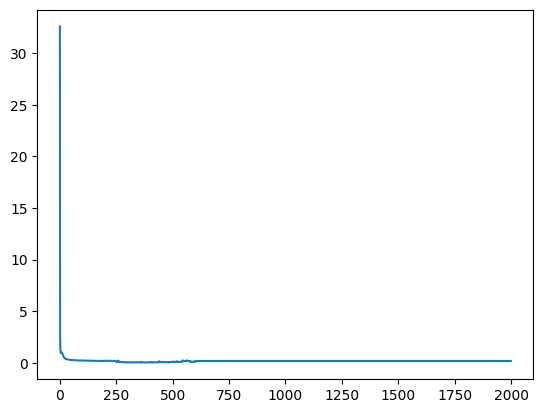

In [13]:
plt.plot(loss_list)

In [14]:
torch.save(model.state_dict(), "TF1_non_ealrystop.pth")

In [21]:
device = torch.device("cuda")

lr = 1e-3
patience = 10
model = TFModel(256, 8, 256, 2, 0.25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
epoch = 2000
patience = 10
loss_list = []

from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
        loss_list.append(batchloss.item())
        
    if (i % patience == 0) & (i != 0):
            
        if loss_list[i - patience] > loss_list[i]:
            print('\n Early Stopping / epoch: %d loss: %.4f'%(i+1, batchloss))
                
            break
                
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.02687:   1%|▋                                                                      | 20/2000 [00:13<22:35,  1.46it/s]


 Early Stopping / epoch: 21 loss: 0.4212


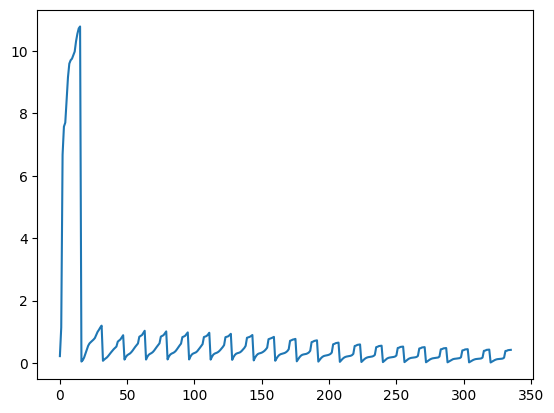

In [17]:
plt.plot(loss_list)

In [18]:
torch.save(model.state_dict(), "TF1_ealrystop.pth")

*   다음 값을 예측하는 과정을 예측할 길이만큼 반복하면서 output을 update함.
*   원하는 길이만큼 예측을 완료하면 return.

In [22]:
def evaluate(length):
    input = torch.tensor(data_train[-200:]).reshape(1,-1,1).to(device).float().to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

In [23]:
result = evaluate(100)
result = min_max_scaler.inverse_transform(result)
real = rawdata["daily_Acc"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [24]:
print(real.shape, result.shape)

(1171, 1) (100, 1)


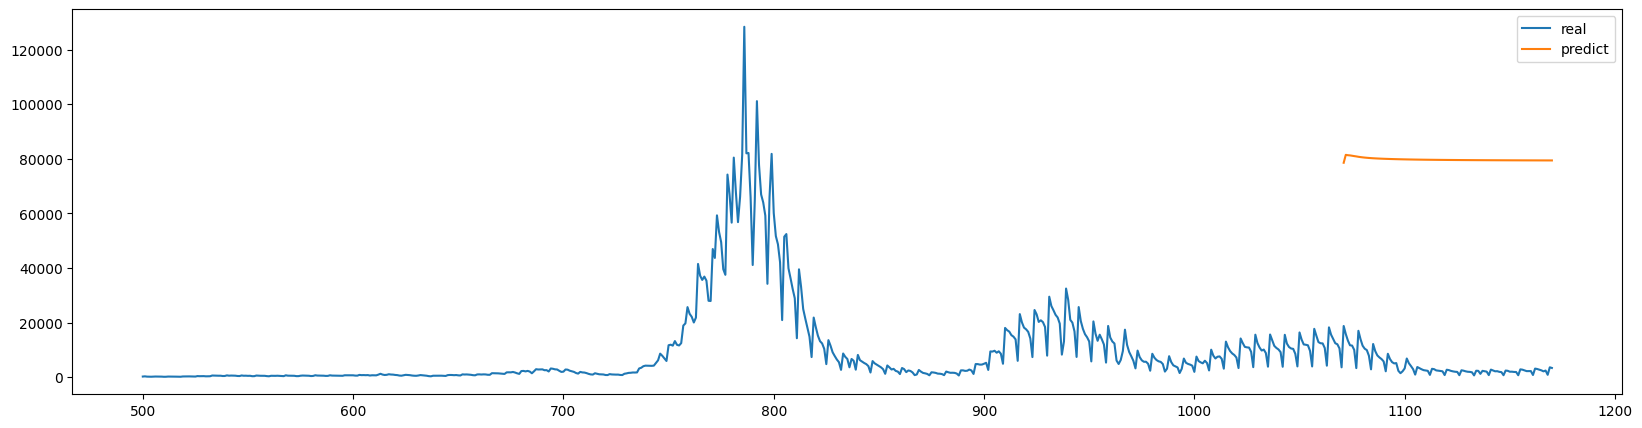

In [25]:
plt.figure(figsize=(20,5))
plt.plot(range(500,1171),real[500:], label="real")
plt.plot(range(1171-100,1171),result, label="predict")
plt.legend()
plt.show()

input의 많은 step의 예측을 반복적으로 디코더에서 한개의 값씩 결과를 예측할 만큼 충분한 정보를 학습하지 못한 것이라 생각.

# FC Layer decoder

*  decoder에서 결과를 반복적으로 1step씩 예측하는 것이 아닌 한번에 예측하는 모델로 다시 모델링.

In [48]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=60, output_window=7, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # input window size의 input data, output window size의 output data.
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

*  return 값이 input, output 두개라는 점이 다름.
------------------------------

In [49]:
iw = 60
ow = 7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# Modeling
transformer decoder를 사용하지 않고 transformer encoder의 output에 FC Layer를 연결해서 결과를 바로 예측한다.

In [10]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.25):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

**다음과 같은 순서로 진행되도록 모델링 했다.**

1. 1차원 벡터를 d_model 차원으로 바꿔준다.
(batch, input_window, 1) => (batch, input_window, d_model)

2. transformer encoder를 통과한다.
(batch, input_window, d_model) => (batch, input_window, d_model)

3. 결과의 d_model차원을 1차원으로 바꿔준다.
(batch, input_window, d_model) => (batch, input_window, 1)

4. 1차원인 부분을 없앤다.
(batch, input_window, 1) => (batch, input_window)

5. input_window차원을 output_window차원으로 바꿔준다.
(batch, input_window) => (batch, output_window)

input window의 attention의 조합으로 output window를 바로 예측할 수 있다는 가정으로 모델을 만들었다.

linear layer들은 두 개씩 쌓아줬다.

In [11]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(60, 7, 512, 8, 4, 0.25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
from tqdm import tqdm

epoch = 2000
patience = 10
loss_list = []

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
        loss_list.append(batchloss.item())
            
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

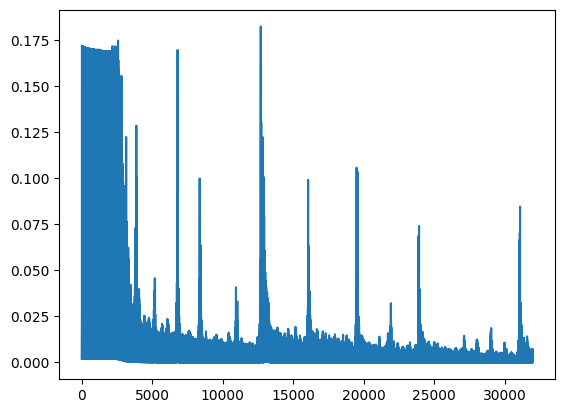

In [40]:
plt.plot(loss_list)

In [41]:
torch.save(model.state_dict(), "TF2_non_earlystop.pth")

In [30]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(60, 7, 512, 8, 4, 0.25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
from tqdm import tqdm

epoch = 2000
patience = 10
loss_list = []

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
        loss_list.append(batchloss.item())
        
    if (i % patience == 0) & (i != 0):
            
        if loss_list[i - patience] > loss_list[i]:
            print('\n Early Stopping / epoch: %d loss: %.4f'%(i+1, batchloss))
                
            break
            
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.010779:   1%|▌                                                             | 20/2000 [01:11<1:57:53,  3.57s/it]


 Early Stopping / epoch: 21 loss: 0.1720


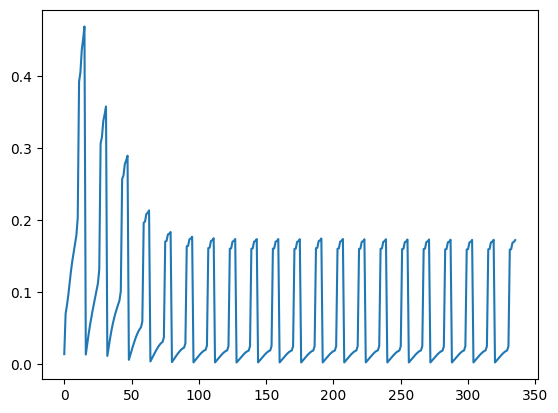

In [32]:
plt.plot(loss_list)

In [33]:
torch.save(model.state_dict(), "TF2_earlystop.pth")

In [52]:
def evaluate():
    input = torch.tensor(data_train[-60:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [53]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["daily_Acc"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]

In [54]:
result

array([ 14409.505 , -21271.816 ,   9123.497 ,   6605.206 ,  18782.66  ,
         8126.1157, -14524.548 ], dtype=float32)

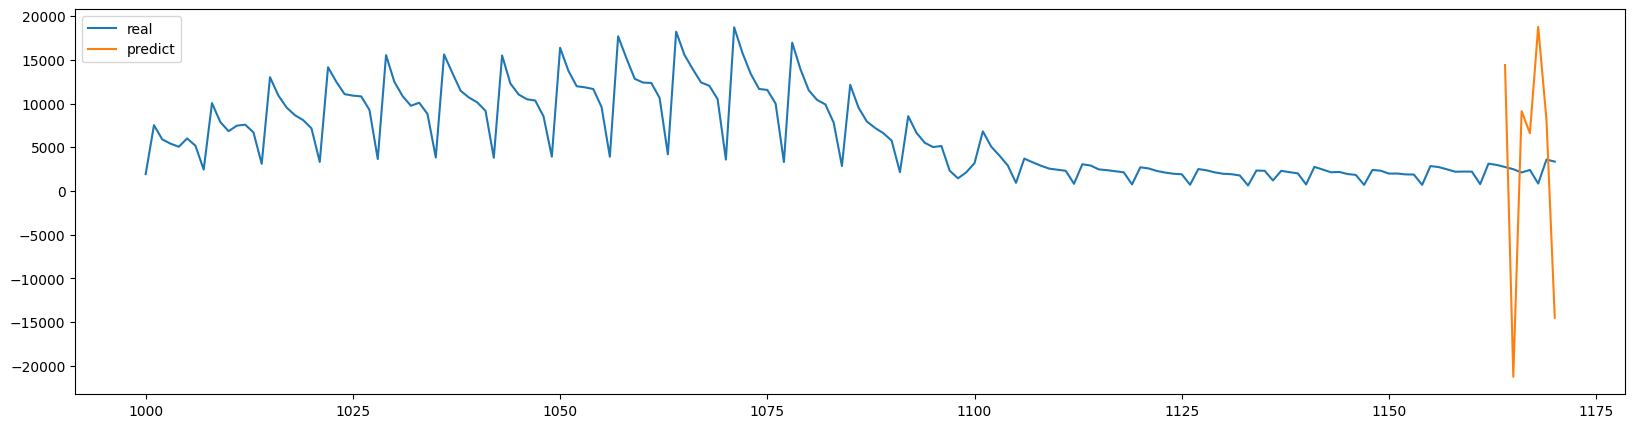

In [55]:
plt.figure(figsize=(20,5))
plt.plot(range(1000,1171),real[1000:], label="real")
plt.plot(range(1171-7,1171),result, label="predict")
plt.legend()
plt.show()

In [40]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-7:])

632.3812605249169

In [11]:
PATH = "TF2_non_earlystop.pth"
model = model = TFModel(60, 7, 512, 8, 4, 0.25)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

TFModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.25, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (li